#  Final Year Project(Support Vector Machine Model)


In [8]:
%matplotlib inline
import pandas as pd
import numpy as np
import ipaddress
import time
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score
)
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


# ============================
# Step 1: Load and Inspect Data
# ============================

In [9]:
print("="*50)
print("STEP 1: Loading and Initial Data Inspection")
print("="*50)

df = pd.read_csv(r'C:\Users\flavi\Downloads\Dataset_output.csv')

print("\nTotal Rows in Dataset:", df.shape[0])
print("\nInitial DataFrame Structure:")
print(df.head())
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values Count:")
print(df.isnull().sum())
print("\nInitial Class Distribution:")
print(df['Attack'].value_counts(dropna=False))


STEP 1: Loading and Initial Data Inspection

Total Rows in Dataset: 11866

Initial DataFrame Structure:
  Timestamp                Source_IPv6           Destination_IPv6 Protocol  \
0         0  fe80::f03a:fcb7:df24:1071  fe80::3fca:458b:5308:ca09   ICMPv6   
1  6.00E-06  fe80::3fca:458b:5308:ca09  fe80::f03a:fcb7:df24:1071   ICMPv6   
2  0.876906  fe80::f03a:fcb7:df24:1071  fe80::3fca:458b:5308:ca09   ICMPv6   
3  0.876914  fe80::3fca:458b:5308:ca09  fe80::f03a:fcb7:df24:1071   ICMPv6   
4  1.879208  fe80::f03a:fcb7:df24:1071  fe80::3fca:458b:5308:ca09   ICMPv6   

   Length                                               Info  Attack  
0     118  Echo (ping) request id=0xa079, seq=10, hop lim...       0  
1     118  Echo (ping) reply id=0xa079, seq=10, hop limit...       0  
2     118  Echo (ping) request id=0xa079, seq=1480, hop l...       0  
3     118  Echo (ping) reply id=0xa079, seq=1480, hop lim...       0  
4     118  Echo (ping) request id=0xa079, seq=3214, hop l...       0  



# ======================
# Step 2: Data Cleaning
# ======================

In [10]:
print("\n" + "="*50)
print("STEP 2: Data Cleaning")
print("="*50)

def parse_timestamp(ts):
    try:
        if isinstance(ts, (int, float)) or (isinstance(ts, str) and ts.replace('.', '', 1).isdigit()):
            return float(ts)
        parsed = pd.to_datetime(ts, format='%m/%d-%H:%M:%S.%f', errors='coerce')
        return parsed.timestamp() if pd.notnull(parsed) else np.nan
    except:
        return np.nan

df['Timestamp'] = df['Timestamp'].apply(parse_timestamp)
df['Timestamp'] = df['Timestamp'] - df['Timestamp'].min()
df['Timestamp'] = df['Timestamp'].fillna(df['Timestamp'].mean())
df['Length'] = df['Length'].replace(0, df['Length'].median())
duplicates = df.duplicated().sum()
if duplicates > 0:
    df = df.drop_duplicates()
print("\nNumber of Duplicate Rows Removed:", duplicates)
df['Attack'] = df['Attack'].astype(int)
print("\nClass Distribution After Cleaning:")
print(df['Attack'].value_counts(dropna=False))


STEP 2: Data Cleaning

Number of Duplicate Rows Removed: 3

Class Distribution After Cleaning:
Attack
1    5933
0    5930
Name: count, dtype: int64


# =====================================================================================
# Step 3: Feature Engineering and Step 3.5: Filter Only ICMPv6 Flood and Normal Traffic
# =====================================================================================

In [11]:
print("\n" + "="*50)
print("STEP 3: Feature Selection and Engineering")
print("="*50)

def ipv6_to_int(ip):
    try:
        return int(ipaddress.IPv6Address(ip))
    except:
        return 0

df['Source_IPv6_int'] = df['Source_IPv6'].apply(ipv6_to_int)
df['Destination_IPv6_int'] = df['Destination_IPv6'].apply(ipv6_to_int)
df['is_ICMPv6_flood'] = df['Info'].str.contains('ICMPv6 Flood Detected', case=False, na=False).astype(int)
df = pd.get_dummies(df, columns=['Protocol'], prefix='Protocol', dummy_na=False)

feature_cols = ['Timestamp', 'Length', 'is_ICMPv6_flood', 'Source_IPv6_int', 'Destination_IPv6_int'] \
               + [col for col in df.columns if col.startswith('Protocol_')]
features = df[feature_cols]
target = df['Attack']

print("\nFeature Statistics:")
print(features.describe())
print("\nClass Distribution:")
print(target.value_counts())

print("\nFiltering dataset to include only ICMPv6 Flood Detected and Normal traffic...")

df_filtered = df[(df['is_ICMPv6_flood'] == 1) | (df['Attack'] == 0)]
features = df_filtered[feature_cols]
target = df_filtered['Attack']

print("Filtered Class Distribution:")
print(target.value_counts())


STEP 3: Feature Selection and Engineering

Feature Statistics:
          Timestamp        Length  is_ICMPv6_flood
count  1.186300e+04  11863.000000     11863.000000
mean   1.098477e+09    118.037764         0.499705
std    1.098568e+09      2.332919         0.500021
min    0.000000e+00    118.000000         0.000000
25%    1.481391e+03    118.000000         0.000000
50%    1.098292e+09    118.000000         0.000000
75%    2.197323e+09    118.000000         1.000000
max    2.197324e+09    290.000000         1.000000

Class Distribution:
Attack
1    5933
0    5930
Name: count, dtype: int64

Filtering dataset to include only ICMPv6 Flood Detected and Normal traffic...
Filtered Class Distribution:
Attack
0    5930
1    5928
Name: count, dtype: int64


# ===========================
# Step 4: Data Preprocessing
# ===========================

In [12]:
print("\n" + "="*50)
print("STEP 4: Data Preprocessing")
print("="*50)

X_train, X_test, y_train, y_test = train_test_split(
    features, target,
    test_size=0.3,
    random_state=42,
    stratify=target
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nTraining set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)
print("\nTraining Class Distribution:")
print(y_train.value_counts())
print("Test Class Distribution:")
print(y_test.value_counts())


STEP 4: Data Preprocessing

Training set shape: (8300, 9)
Test set shape: (3558, 9)

Training Class Distribution:
Attack
0    4151
1    4149
Name: count, dtype: int64
Test Class Distribution:
Attack
1    1779
0    1779
Name: count, dtype: int64


# ===========================
# Step 5: SVM Model Training
# ===========================

In [13]:
print("\n" + "="*50)
print("STEP 5: SVM Model Training")
print("="*50)

train_start_time = time.time()

svm_model = SVC(
    kernel='linear',
    C=1.0,
    random_state=42,
    class_weight='balanced',
    probability=True
)
svm_model.fit(X_train_scaled, y_train)

train_end_time = time.time()
train_duration = train_end_time - train_start_time

print("\nModel training completed.")
print(f"Training Time: {train_duration:.2f} seconds")
print(f"Number of support vectors per class: {svm_model.n_support_}")

# Save the trained SVM model and scaler
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(feature_cols, 'feature_cols.pkl')

print("\nModel and scaler saved successfully:")
print("- SVM Model: svm_model.pkl")
print("- Scaler: scaler.pkl")
print("- Feature Columns: feature_cols.pkl")

pipeline = make_pipeline(StandardScaler(), SVC(kernel='linear', C=1.0, random_state=42, class_weight='balanced'))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, features, target, cv=skf)

print("\nCross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())


STEP 5: SVM Model Training

Model training completed.
Training Time: 0.02 seconds
Number of support vectors per class: [1 1]

Model and scaler saved successfully:
- SVM Model: svm_model.pkl
- Scaler: scaler.pkl
- Feature Columns: feature_cols.pkl

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Score: 1.0


# =======================
# Step 6: Model Evaluation
# =======================


STEP 6: Model Evaluation

Prediction Time: 0.00 seconds

Confusion Matrix (Text Representation):
                   Predicted
                   Normal (0)  Attack (1)
Actual Normal (0)      1779       0         
Actual Attack (1)      0          1779      


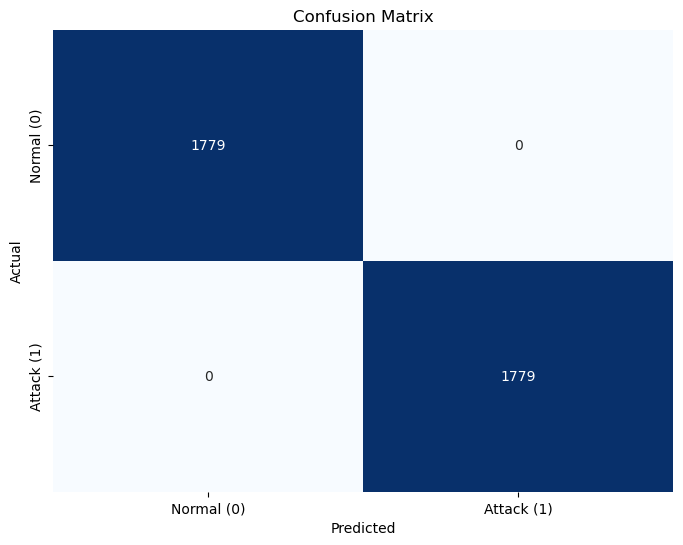


ROC Curve Summary:
AUC: 1.0000
  FPR: 0.0000, TPR: 0.0000, Threshold: inf
  FPR: 0.0000, TPR: 0.3749, Threshold: 1.0000
  FPR: 0.0000, TPR: 0.7572, Threshold: 1.0000
  FPR: 0.1625, TPR: 1.0000, Threshold: 0.0002
  FPR: 0.5767, TPR: 1.0000, Threshold: 0.0002
  FPR: 0.9944, TPR: 1.0000, Threshold: 0.0002


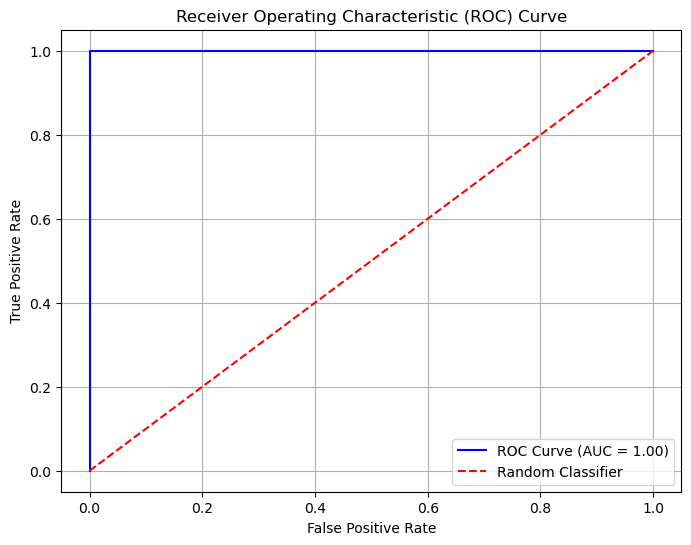


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1779
           1       1.00      1.00      1.00      1779

    accuracy                           1.00      3558
   macro avg       1.00      1.00      1.00      3558
weighted avg       1.00      1.00      1.00      3558


Accuracy: 1.0000


In [14]:
print("\n" + "="*50)
print("STEP 6: Model Evaluation")
print("="*50)

pred_start_time = time.time()
y_pred = svm_model.predict(X_test_scaled)
y_proba = svm_model.predict_proba(X_test_scaled)[:, 1]
pred_end_time = time.time()
pred_duration = pred_end_time - pred_start_time

print(f"\nPrediction Time: {pred_duration:.2f} seconds")

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix (Text Representation):")
print("                   Predicted")
print("                   Normal (0)  Attack (1)")
print(f"Actual Normal (0)      {cm[0,0]:<10} {cm[0,1]:<10}")
print(f"Actual Attack (1)      {cm[1,0]:<10} {cm[1,1]:<10}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal (0)', 'Attack (1)'],
            yticklabels=['Normal (0)', 'Attack (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

print("\nROC Curve Summary:")
print(f"AUC: {auc:.4f}")
for i in range(0, len(fpr), max(1, len(fpr)//5)):
    print(f"  FPR: {fpr[i]:.4f}, TPR: {tpr[i]:.4f}, Threshold: {thresholds[i]:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")



# ===========================
# Step 7: Model Interpretation
# ===========================


STEP 7: Model Interpretation

Feature Weights from SVM Model (Raw, Normalized, Absolute):
                Feature    Weight  Normalized_Weight  Abs_Weight  \
2       is_ICMPv6_flood  0.307671           1.000000    0.307671   
6       Protocol_ICMPv6 -0.307671           0.000000    0.307671   
7    Protocol_IPV6-ICMP  0.307671           1.000000    0.307671   
0             Timestamp -0.153906           0.249885    0.153906   
1                Length  0.000000           0.500000    0.000000   
3       Source_IPv6_int  0.000000           0.500000    0.000000   
4  Destination_IPv6_int  0.000000           0.500000    0.000000   
5         Protocol_ICMP  0.000000           0.500000    0.000000   
8          Protocol_UDP  0.000000           0.500000    0.000000   

   Abs_Normalized_Weight  
2               1.000000  
6               1.000000  
7               1.000000  
0               0.500229  
1               0.000000  
3               0.000000  
4               0.000000  
5           

C:\Users\flavi\AppData\Local\Temp\ipykernel_39704\615546714.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Abs_Normalized_Weight', y='Feature', data=feature_importance_sorted, palette='coolwarm')


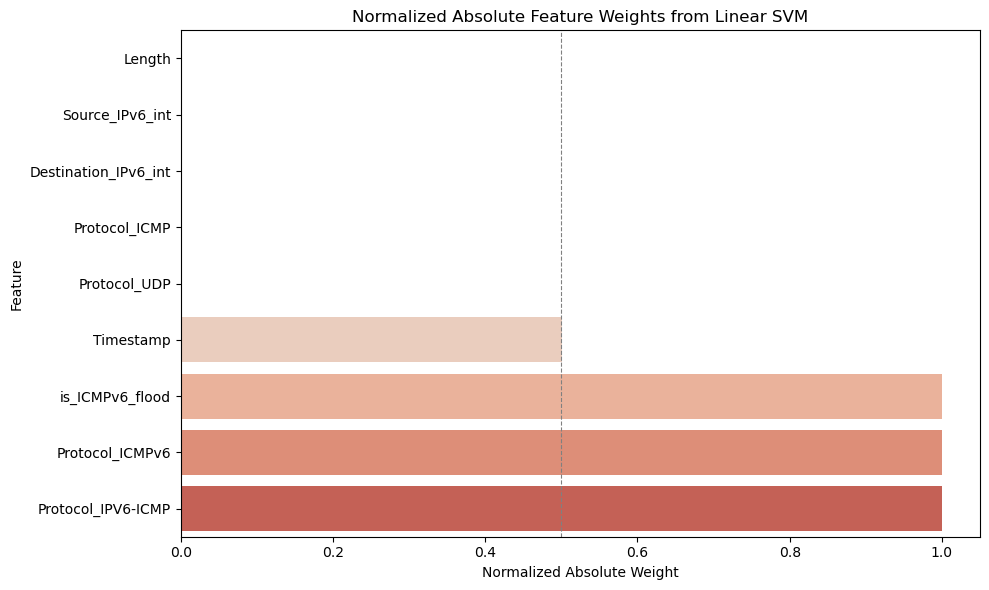

In [15]:
print("\n" + "="*50)
print("STEP 7: Model Interpretation")
print("="*50)

# Get raw coefficients from the trained SVM model
coefficients = svm_model.coef_[0]

# Create DataFrame with raw weights
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Weight': coefficients
})

# Calculate absolute weights
feature_importance['Abs_Weight'] = feature_importance['Weight'].abs()

# Normalize the raw weights (min-max normalization)
min_w = feature_importance['Weight'].min()
max_w = feature_importance['Weight'].max()
if max_w != min_w:
    feature_importance['Normalized_Weight'] = (feature_importance['Weight'] - min_w) / (max_w - min_w)
else:
    feature_importance['Normalized_Weight'] = 0.0  # all weights are equal

# Normalize the absolute weights (min-max normalization)
min_abs = feature_importance['Abs_Weight'].min()
max_abs = feature_importance['Abs_Weight'].max()
if max_abs != min_abs:
    feature_importance['Abs_Normalized_Weight'] = (feature_importance['Abs_Weight'] - min_abs) / (max_abs - min_abs)
else:
    feature_importance['Abs_Normalized_Weight'] = 0.0

# Sort for visual clarity (optional: descending by absolute normalized weight)
feature_importance_sorted = feature_importance.sort_values('Abs_Normalized_Weight', ascending=True)

# Print feature weights
print("\nFeature Weights from SVM Model (Raw, Normalized, Absolute):")
print(feature_importance.sort_values('Abs_Normalized_Weight', ascending=False)[
    ['Feature', 'Weight', 'Normalized_Weight', 'Abs_Weight', 'Abs_Normalized_Weight']
])

# Plot horizontal bar plot using normalized absolute weights
plt.figure(figsize=(10, 6))
sns.barplot(x='Abs_Normalized_Weight', y='Feature', data=feature_importance_sorted, palette='coolwarm')
plt.title('Normalized Absolute Feature Weights from Linear SVM')
plt.xlabel('Normalized Absolute Weight')
plt.ylabel('Feature')
plt.tight_layout()
plt.axvline(0.5, color='gray', linestyle='--', linewidth=0.8)  # Optional midpoint marker
plt.show()

# Comparison of Snort vs SVM vs ANN

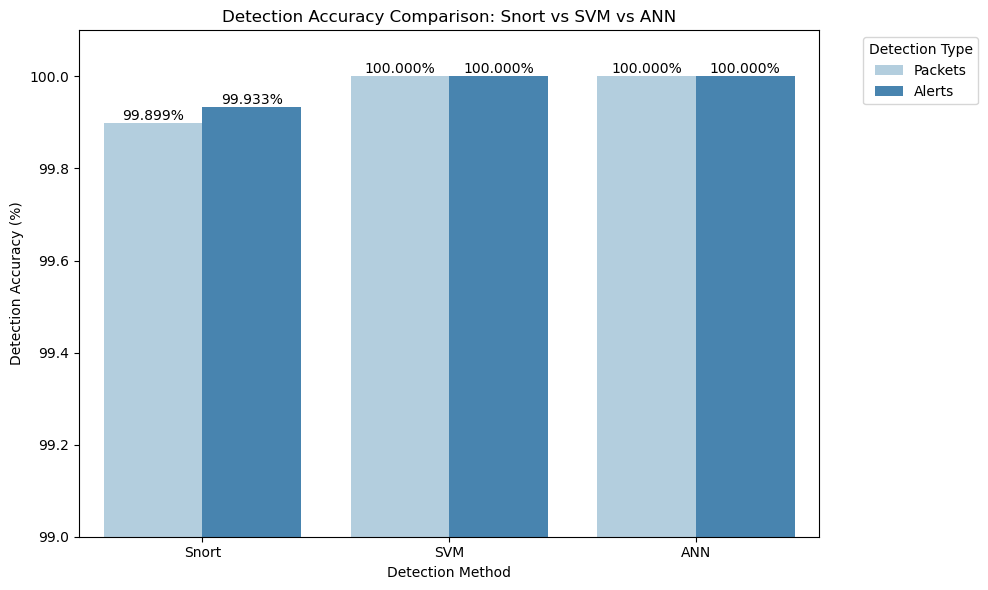

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Updated detection counts
total_packets = 5930
total_alerts = 5928

data = {
    'Method': ['Snort', 'Snort', 'SVM', 'SVM', 'ANN', 'ANN'],
    'Type': ['Packets', 'Alerts', 'Packets', 'Alerts', 'Packets', 'Alerts'],
    'Accuracy': [
        (5924 / total_packets) * 100,   # Snort Packets
        (5924 / total_alerts) * 100,    # Snort Alerts
        (5930 / total_packets) * 100,   # SVM Packets
        (5928 / total_alerts) * 100,    # SVM Alerts
        (5930 / total_packets) * 100,   # ANN Packets
        (5928 / total_alerts) * 100     # ANN Alerts
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Method', y='Accuracy', hue='Type', data=df, palette='Blues')

# Customize plot
plt.ylabel('Detection Accuracy (%)')
plt.xlabel('Detection Method')
plt.ylim(99, 100.1)  # Set y-axis range slightly above 100% to fit labels
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.3f%%', label_type='edge')
plt.legend(title='Detection Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Detection Accuracy Comparison: Snort vs SVM vs ANN")
plt.tight_layout()

# Show plot
plt.show()
